<a href="https://colab.research.google.com/github/tjohanne42/time_series_project_simplon/blob/main/preprocess_data_theo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
!git clone https://github.com/tjohanne42/time_series_project_simplon.git

fatal: destination path 'time_series_project_simplon' already exists and is not an empty directory.


In [7]:
from time_series_project_simplon.utils.functions import generate_df_by_time_section
from time_series_project_simplon.utils import functions

# I. Load data

In [11]:
# dir(functions)

In [57]:
df_raw = generate_df_by_time_section(time_section="day", verbose=True)
df_raw.tail()

set seconds, minutes and hours to 0 ...


  0%|          | 0/796411 [00:00<?, ?it/s]

get the mean values for every day ...
multiply all values by 12 * 24 to get the actual values by day ...
done


,timestamp,coal,nuclear,wind,hydro,solar
2767,2019-07-30,0.0,1.573999e+06,1.233718e+06,73637.000000,376435.335097
2768,2019-07-31,0.0,1.606865e+06,1.685585e+06,92945.000000,355390.763997
2769,2019-08-01,0.0,1.606940e+06,6.505120e+05,117124.000000,519328.582901
2770,2019-08-02,0.0,1.592180e+06,2.959050e+05,115334.000000,596295.099905
2771,2019-08-03,0.0,1.567348e+06,1.844990e+05,90230.518519,607272.596147


# II. Train & Pred

In [74]:
from math import sqrt
import os
from tqdm import tqdm

import keras
from keras.utils.vis_utils import plot_model
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, LSTM, Conv1D, GlobalMaxPooling1D, SimpleRNN

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tqdm.keras import TqdmCallback

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

In [132]:
col = "nuclear"

print(df_raw.shape)
display(df_raw.head())
df_raw.info()

(2772, 6)


,timestamp,coal,nuclear,wind,hydro,solar
0,2012-01-01,2.448325e+06,2.029537e+06,760388.000000,226484.000000,0.0
1,2012-01-02,2.938653e+06,2.037884e+06,795531.261324,224000.780488,0.0
2,2012-01-03,4.430877e+06,2.005847e+06,621916.000000,231623.000000,0.0
3,2012-01-04,4.903744e+06,2.039013e+06,764407.000000,232221.000000,0.0
4,2012-01-05,4.765032e+06,2.171748e+06,760181.000000,238301.000000,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2772 entries, 0 to 2771
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  2772 non-null   datetime64[ns]
 1   coal       2772 non-null   float64       
 2   nuclear    2772 non-null   float64       
 3   wind       2772 non-null   float64       
 4   hydro      2772 non-null   float64       
 5   solar      2772 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 151.6 KB


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


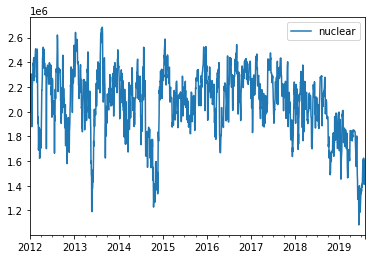

,nuclear
2012-01-01,2.029537e+06
2012-01-02,2.037884e+06
2012-01-03,2.005847e+06
2012-01-04,2.039013e+06
2012-01-05,2.171748e+06


In [133]:
df = df_raw[["timestamp", col]]
df.set_index(df["timestamp"].values, drop=True, inplace=True)
df.drop("timestamp", axis=1, inplace=True)
df.plot()
plt.show()
df.head()

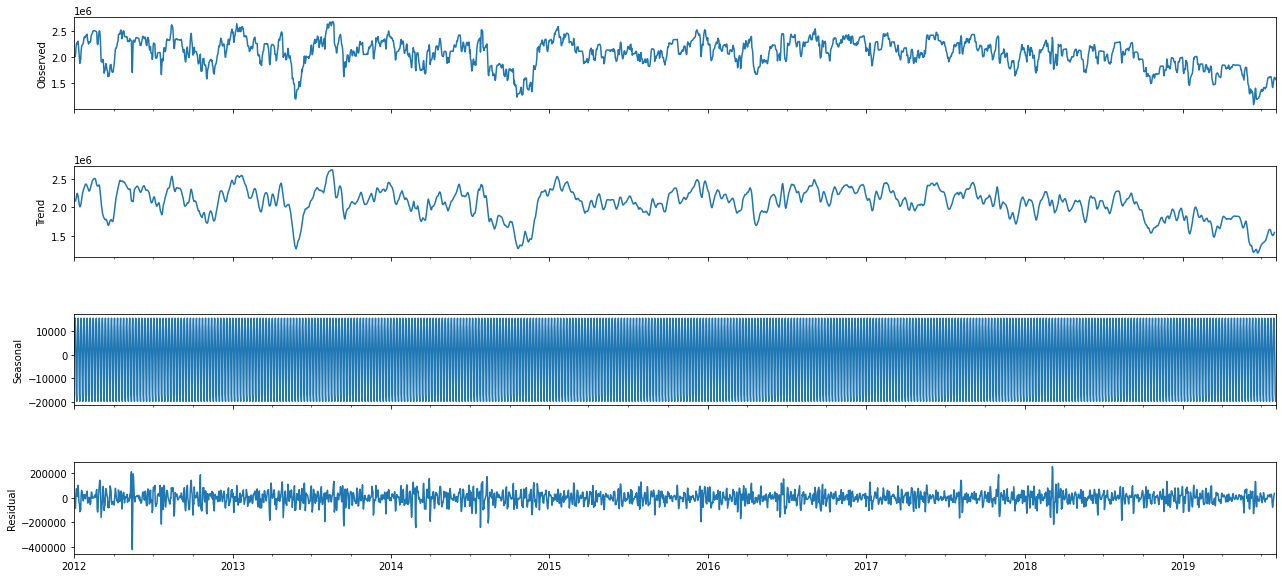

In [134]:
decomposition = seasonal_decompose(df)
fig = decomposition.plot();
fig.set_size_inches(21, 9)

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


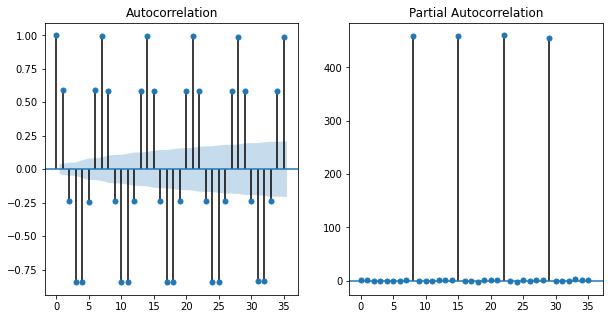

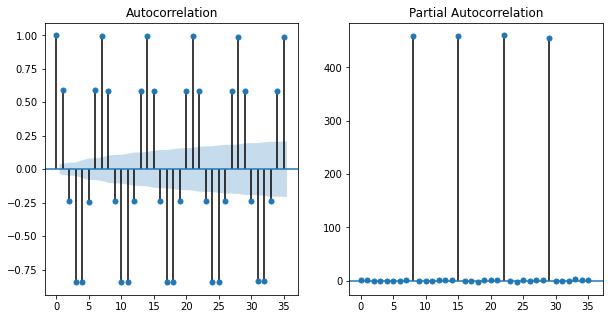

In [135]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

plot_acf(decomposition.seasonal, ax=ax[0])
plot_pacf(decomposition.seasonal, ax=ax[1])

In [136]:
# Divide data into train and test sets
train_split_percent = 0.75

train_split_percent = int(df.shape[0] * train_split_percent)

train = df.iloc[:train_split_percent]
test = df.iloc[train_split_percent:]

In [138]:
# Normalize training data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(train)
 
# Create supervised data with 12 inputs and 1 output
n_lag = 30
X_train = []
y_train = []
for i in range(n_lag, len(train) - n_lag):
    X_train.append(train_scaled[i-n_lag:i, 0])
    y_train.append(train_scaled[i:i+n_lag, 0])
 
X_train, y_train = np.array(X_train), np.array(y_train)
 
# Reshape train set
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [140]:
inputs = Input(shape=(X_train.shape[1], 1))

main = Dense(n_lag, activation="relu")(inputs)

main = LSTM(256, activation="tanh", recurrent_activation="sigmoid", return_sequences=True)(main)
main = LSTM(256, activation="tanh", recurrent_activation="sigmoid", return_sequences=True)(main)
main = LSTM(128, activation="tanh", recurrent_activation="sigmoid", return_sequences=True)(main)
main = LSTM(64, activation="tanh", recurrent_activation="sigmoid")(main)

main = Dense(n_lag, activation=None, name='output')(main)

model = Model(inputs, main)

model.summary()
plot_model(model, to_file="blbl.png", show_shapes=True)

model.compile(
  optimizer = Adam(learning_rate=0.001),
  loss = "mae",
)

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 30, 1)]           0         
_________________________________________________________________
dense_10 (Dense)             (None, 30, 30)            60        
_________________________________________________________________
lstm_40 (LSTM)               (None, 30, 256)           293888    
_________________________________________________________________
lstm_41 (LSTM)               (None, 30, 256)           525312    
_________________________________________________________________
lstm_42 (LSTM)               (None, 30, 128)           197120    
_________________________________________________________________
lstm_43 (LSTM)               (None, 64)                49408     
_________________________________________________________________
output (Dense)               (None, 30)                195

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

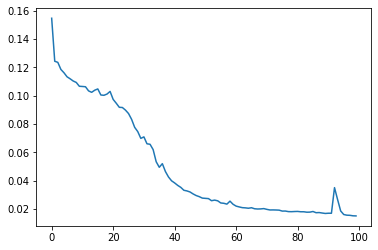

In [141]:
if not os.path.isdir("model"):
  os.system("mkdir model")

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="model/model.h5",
    mode='max',
    save_best_only=True)

history = model.fit(
      X_train,
      y_train,
      validation_split=0.2,
      epochs=100,
      verbose=0,
      batch_size=16,
      callbacks=[model_checkpoint_callback, TqdmCallback(verbose=2)]
  )

# show loss
loss_per_epoch = model.history.history["loss"]
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)
plt.show()

## b) predict

In [126]:
predict = pd.DataFrame(test.values)
predict.columns = [col]
predict.index = test.index
predict

,nuclear
2017-09-10,2.293252e+06
2017-09-11,2.293627e+06
2017-09-12,2.185045e+06
2017-09-13,2.151942e+06
2017-09-14,2.139938e+06
...,...
2019-07-30,1.573999e+06
2019-07-31,1.606865e+06
2019-08-01,1.606940e+06
2019-08-02,1.592180e+06


pred_t+1_from_true_values

In [127]:
inputs = df[len(df) - len(test) - n_lag:].values

inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(n_lag, n_lag+len(test)):
    X_test.append(inputs[i-n_lag:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
 
# Forecast
predict_scaled = model.predict(X_test)
pred_tab = []
for tmp in predict_scaled:
  pred_tab.append(tmp[0])
predict_scaled = sc.inverse_transform(np.reshape(pred_tab, (-1, 1)))

predict['pred_t+1_from_true_values'] = predict_scaled

pred n_lag by n_lag

In [128]:
test_predictions = []
first_batch_for_prediction = train_scaled[-n_lag :]
current_batch = first_batch_for_prediction.reshape((1, n_lag, 1))


for index in tqdm(range(0, len(test), n_lag)):

  current_prediction = model.predict(current_batch)[0]

  test_predictions += list(current_prediction)

  current_batch = current_prediction.reshape((1, n_lag, 1))

test_predictions_unnormalized = sc.inverse_transform(np.reshape(test_predictions, (-1, 1)))

predict["pred n_lag by n_lag"] = test_predictions_unnormalized[:predict.shape[0]]



  0%|          | 0/24 [00:00<?, ?it/s]

  8%|▊         | 2/24 [00:00<00:01, 16.62it/s]

 17%|█▋        | 4/24 [00:00<00:01, 16.25it/s]

 25%|██▌       | 6/24 [00:00<00:01, 16.47it/s]

 33%|███▎      | 8/24 [00:00<00:00, 16.36it/s]

 42%|████▏     | 10/24 [00:00<00:00, 16.39it/s]

 50%|█████     | 12/24 [00:00<00:00, 15.71it/s]

 58%|█████▊    | 14/24 [00:00<00:00, 15.96it/s]

 67%|██████▋   | 16/24 [00:00<00:00, 15.96it/s]

 75%|███████▌  | 18/24 [00:01<00:00, 16.06it/s]

 83%|████████▎ | 20/24 [00:01<00:00, 15.02it/s]

 92%|█████████▏| 22/24 [00:01<00:00, 15.24it/s]

100%|██████████| 24/24 [00:01<00:00, 15.72it/s]


pred 1 by 1



  0%|          | 0/693 [00:00<?, ?it/s]

  0%|          | 2/693 [00:00<00:38, 17.74it/s]

  1%|          | 4/693 [00:00<00:40, 16.84it/s]

  1%|          | 6/693 [00:00<00:44, 15.61it/s]

  1%|          | 8/693 [00:00<00:47, 14.49it/s]

  1%|▏         | 10/693 [00:00<00:44, 15.22it/s]

  2%|▏         | 12/693 [00:00<00:45, 15.07it/s]

  2%|▏         | 14/693 [00:00<00:43, 15.48it/s]

  2%|▏         | 16/693 [00:01<00:44, 15.12it/s]

  3%|▎         | 18/693 [00:01<00:43, 15.35it/s]

  3%|▎         | 20/693 [00:01<00:46, 14.54it/s]

  3%|▎         | 22/693 [00:01<00:47, 14.02it/s]

  3%|▎         | 24/693 [00:01<00:46, 14.53it/s]

  4%|▍         | 26/693 [00:01<00:45, 14.53it/s]

  4%|▍         | 28/693 [00:01<00:45, 14.60it/s]

  4%|▍         | 30/693 [00:02<00:44, 14.85it/s]

  5%|▍         | 32/693 [00:02<00:44, 14.77it/s]

  5%|▍         | 34/693 [00:02<00:42, 15.54it/s]

  5%|▌         | 36/693 [00:02<00:44, 14.69it/s]

  5%|▌         | 38/693 [00:02<00:45, 14.50it/s]

  6%|▌     

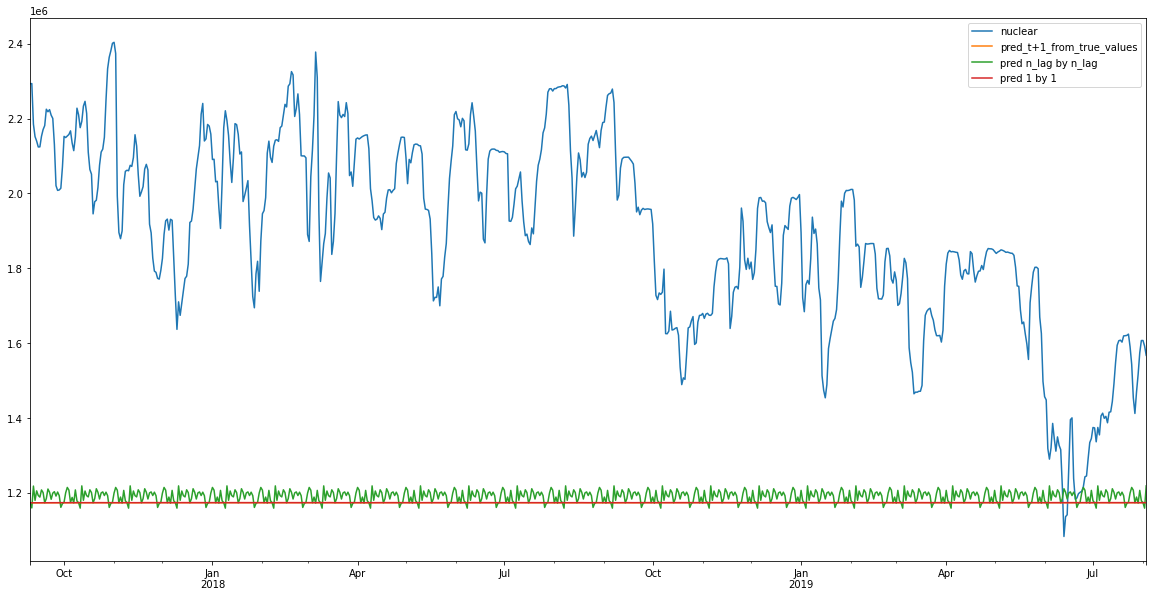

In [129]:
test_predictions = []
first_batch_for_prediction = train_scaled[-n_lag :]
current_batch = first_batch_for_prediction.reshape((1, n_lag, 1))

for index in tqdm(range(0, len(test))):

  current_prediction = model.predict(current_batch)[0][0]

  test_predictions.append(current_prediction)

  current_batch = np.append(current_batch[:, 1:, :], [[[current_prediction]]], axis=1)


test_predictions_unnormalized = sc.inverse_transform(np.reshape(test_predictions, (-1, 1)))

predict["pred 1 by 1"] = test_predictions_unnormalized[:predict.shape[0]]
predict.plot(figsize=(20,10))

## b) Metrics

In [130]:
for tmp_col in predict.columns:
  if "pred" in tmp_col:
    print("col name:", tmp_col)

    rmse = sqrt(mean_squared_error(predict[col], predict[tmp_col]))
    print("rmse:", rmse)

col name: pred_t+1_from_true_values
rmse: 768024.7304140356
col name: pred n_lag by n_lag
rmse: 752272.2735782838
col name: pred 1 by 1
rmse: 767933.4022972324
